# Simplified detection of urban types

Example adapted from the [SDSC 2021 Workshop](https://github.com/martinfleis/sdsc21-workshop) led by Martin Fleischmann. You can see the recording of the workshop on [YouTube](https://www.youtube.com/watch?v=itUX56Ks1UE).

This example illustrates the potential of morphometrics captured by `momepy` in capturing the structure of cities. We will pick a town, fetch its data from the OpenStreetMap, and analyse it to detect individual types of urban structure within it.

This method is only illustrative and is based on the more extensive one published by Fleischmann et al. (2021) available from [https://github.com/martinfleis/numerical-taxonomy-paper](https://github.com/martinfleis/numerical-taxonomy-paper).

> Fleischmann M, Feliciotti A, Romice O and Porta S (2021) Methodological Foundation of a Numerical Taxonomy of Urban Form. Environment and Planning B: Urban Analytics and City Science, doi: 10.1177/23998083211059835

It depends on the following packages:

```
- momepy
- osmnx
- clustergram
- bokeh
- scikit-learn
- geopy
- ipywidgets
```


In [1]:
import geopandas as gpd
import libpysal
import matplotlib.pyplot as plt
import momepy

import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram

output_notebook()

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = "Znojmo, Czechia"
local_crs = 5514

We can interactively explore the place we just selected.

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

We can use ``OSMnx`` to quickly download data from OpenStreetMap. If you intend to download larger areas, we recommend using ``pyrosm`` instead.

### Buildings

In [4]:
buildings = osmnx.features_from_place(place, tags={"building": True})
buildings.head()

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


power                   geometry amenity brand  \
element_type osmid                                                       
node         3372076291   NaN  POINT (16.05376 48.84683)     NaN   NaN   
             3372076393   NaN  POINT (16.05581 48.84158)     NaN   NaN   
             3372076394   NaN  POINT (16.05867 48.83522)     NaN   NaN   
             3372076428   NaN  POINT (16.03949 48.85599)     NaN   NaN   
             3372076429   NaN  POINT (16.04133 48.85501)     NaN   NaN   

                        brand:wikidata brand:wikipedia check_date  \
element_type osmid                                                  
node         3372076291            NaN             NaN        NaN   
             3372076393            NaN             NaN        NaN   
             3372076394            NaN             NaN        NaN   
             3372076428            NaN             NaN        NaN   
             3372076429            NaN             NaN        NaN   

                                   name operator operator:wikidata  ...  \
element_type osmid                                                  ...   
node         3372076291    7/I/10/A-120      NaN               NaN  ...   
             3372076393  7/I/11/A-140 Z      NaN               NaN  ...   
             3372076394    7/I/12/A-220      NaN               NaN  ...   
             3372076428         7/I/8/E      NaN               NaN  ...   
             3372076429         7/I/9/E      NaN               NaN  ...   

                        material name:signed  ref monitoring:water_level  \
element_type osmid                                                         
node         3372076291      NaN         NaN  NaN                    NaN   
             3372076393      NaN         NaN  NaN                    NaN   
             3372076394      NaN         NaN  NaN                    NaN   
             3372076428      NaN         NaN  NaN                    NaN   
             3372076429      NaN         NaN  NaN                    NaN   

                        takeaway shelter_type construction ways type emergency  
element_type osmid                                                              
node         3372076291      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076393      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076394      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076428      NaN          NaN          NaN  NaN  NaN       NaN  
             3372076429      NaN          NaN          NaN  NaN  NaN       NaN  

[5 rows x 119 columns]

<Axes: >

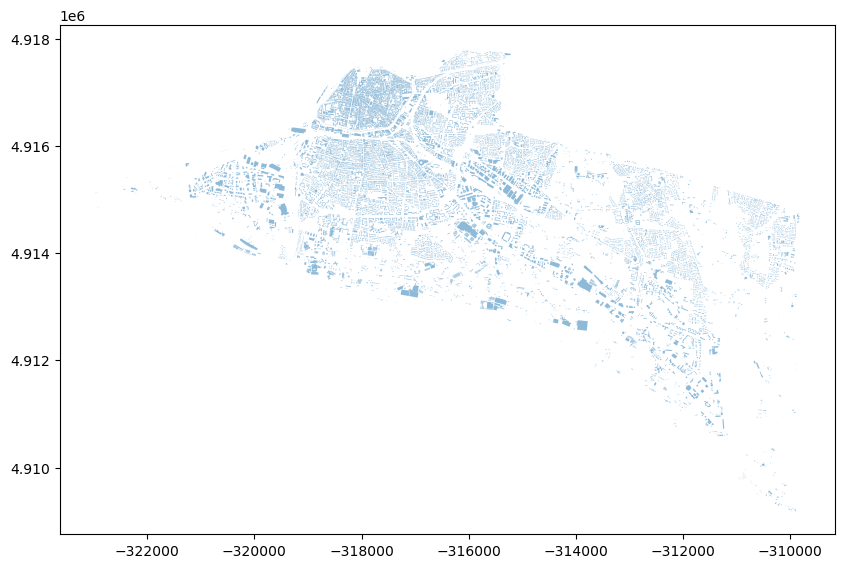

In [11]:
buildings.plot(figsize=(10, 10), alpha=0.5)

The OSM input may need a bit of cleaning to ensure only proper polygons are kept.

In [12]:
buildings.geom_type.value_counts()

Polygon    39336
Name: count, dtype: int64

## Read buildings data

In [2]:
path = r"C:\Users\edoar\OneDrive\Desktop\test\bl2.shp"
layer = "bl2"
buildings = gpd.read_file(path, layer=layer)

In [3]:
buildings = buildings.explode(index_parts=False).reset_index(drop=True)
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

And we should re-project the data from WGS84 to the local projection in meters (momepy default values assume meters not feet or degrees). We will also drop unnecessary columns.

In [4]:
buildings = buildings[["geometry"]].to_crs(epsg=32633)
buildings.head()

geometry
0  POLYGON ((-310221.405 4914863.983, -310225.022...
1  POLYGON ((-310225.022 4914864.396, -310221.405...
2  POLYGON ((-310222.394 4914856.896, -310222.877...
3  POLYGON ((-310233.408 4914817.823, -310221.644...
4  POLYGON ((-310200.44 4914883.629, -310194.169 ...

### Streets

Similar operations are done with streets.

In [8]:
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/graph.py:392: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


osmid  ref        name      highway maxspeed  oneway reversed   length  \
0  33733060  361  Přímětická    secondary       50   False     True   24.574   
1  33733060  361  Přímětická    secondary       50   False    False   60.354   
2  50313252  NaN     Raisova  residential      NaN    True    False   74.763   
3  33733060  361  Přímětická    secondary       50   False     True   54.260   
4  50313241  NaN  Mičurinova  residential      NaN    True    False  101.376   

         from         to                                           geometry  \
0   639231391   74103628  LINESTRING (-643229.639 -1192872.949, -643239....   
1  3775990798   74103628  LINESTRING (-643236.395 -1192790.304, -643237....   
2   639231413   74103628  LINESTRING (-643291.344 -1192797.012, -643288....   
3    74142638  639231391  LINESTRING (-643205.434 -1192921.533, -643219....   
4   639231391  639231314  LINESTRING (-643229.639 -1192872.949, -643233....   

  lanes bridge junction width tunnel access  
0   NaN    NaN      NaN   NaN    NaN    NaN  
1   NaN    NaN      NaN   NaN    NaN    NaN  
2   NaN    NaN      NaN   NaN    NaN    NaN  
3   NaN    NaN      NaN   NaN    NaN    NaN  
4   NaN    NaN      NaN   NaN    NaN    NaN

In [5]:
path = r"C:\Users\edoar\OneDrive\Desktop\test\Avignon_Roads.gpkg"
layer = "Avignon_roads"
streets = gpd.read_file(path, layer=layer)

We can also do some preprocessing using momepy to ensure we have proper network topology.

In [6]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\utils.py:351: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [7]:
streets.head()

geometry
0  LINESTRING (4.75769 43.93375, 4.75806 43.93349...
1  LINESTRING (4.74943 43.92585, 4.74936 43.92527...
2  LINESTRING (4.75067 43.92692, 4.75053 43.92689...
3  LINESTRING (4.75151 43.92678, 4.75141 43.92683...
4  LINESTRING (4.75034 43.9291, 4.75012 43.929, 4...

In [8]:
streets = streets.to_crs(epsg=32633)

## Generated data

### Tessellation

Given building footprints:

![blg](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_3_0.png)

We can generate a spatial unit using morphological tessellation:

![tess](https://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_9_0.png)

In [9]:
limit = momepy.buffered_limit(buildings, "adaptive")

tessellation = momepy.morphological_tessellation(buildings, clip=limit)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\libpysal\graph\base.py:1375: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _gabriel(


OpenStreetMap data are often problematic due to low quality of some polygons. If some collapse, we get a mismatch between the length of buildings and the length of polygons.

In [10]:
collapsed, _ = momepy.verify_tessellation(tessellation, buildings)

C:\Users\edoar\AppData\Local\Temp\ipykernel_10040\3509021287.py:1: UserWarning: Tessellation does not fully match buildings. 50 element(s) disappeared during generation. Index of the affected elements: Index([  150,   152,   157,   167,  2101,  2113,  2453,  2459,  2460,  2464,
        2471,  3064,  3403,  3454,  4234,  4274,  4320,  4328,  4867,  6019,
        6027,  6162,  6785,  8624, 10916, 11527, 12041, 12728, 12732, 12984,
       14597, 15646, 15712, 15937, 16948, 21302, 22019, 24699, 24736, 27323,
       29524, 29627, 32854, 32857, 32860, 32956, 34958, 35324, 36557, 37136],
      dtype='int64').
  collapsed, _ = momepy.verify_tessellation(tessellation, buildings)
C:\Users\edoar\AppData\Local\Temp\ipykernel_10040\3509021287.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [806, 957, 1073, 1332, 1407, 1436, 1923, 3027, 3196, 3263, 3277, 3363, 3408, 3416, 3526, 3625, 3660, 3665, 3945, 4046, 4167, 4475, 47

Better to drop affected buildings and re-create tessellation.

In [11]:
buildings = buildings.drop(collapsed)
limit = momepy.buffered_limit(buildings, "adaptive")
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\libpysal\graph\base.py:1375: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _gabriel(


Check the result.

In [12]:
tessellation.shape[0] == buildings.shape[0]

True

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [13]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=100
)
buildings

geometry  street_index
0      POLYGON ((-310221.405 4914863.983, -310225.022...       20759.0
1      POLYGON ((-310225.022 4914864.396, -310221.405...       20759.0
2      POLYGON ((-310222.394 4914856.896, -310222.877...       20759.0
3      POLYGON ((-310233.408 4914817.823, -310221.644...       20759.0
4      POLYGON ((-310200.44 4914883.629, -310194.169 ...       20759.0
...                                                  ...           ...
39331  POLYGON ((-322204.684 4915171.714, -322192.629...        4851.0
39332  POLYGON ((-322936.215 4915308.231, -322931.248...           4.0
39333  POLYGON ((-322966.624 4915131.783, -322965.943...           4.0
39334  POLYGON ((-322959.097 4915121.693, -322958.447...           4.0
39335  POLYGON ((-322974.794 4914890.719, -322974.011...        4826.0

[39286 rows x 2 columns]

Aattach the network index to the tessellation as well.

In [14]:
tessellation["street_index"] = buildings["street_index"]

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [15]:
buildings["building_area"] = buildings.area
tessellation["tess_area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [16]:
buildings["eri"] = momepy.equivalent_rectangular_index(buildings)
buildings["elongation"] = momepy.elongation(buildings)
tessellation["convexity"] = momepy.convexity(tessellation)
streets["linearity"] = momepy.linearity(streets)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


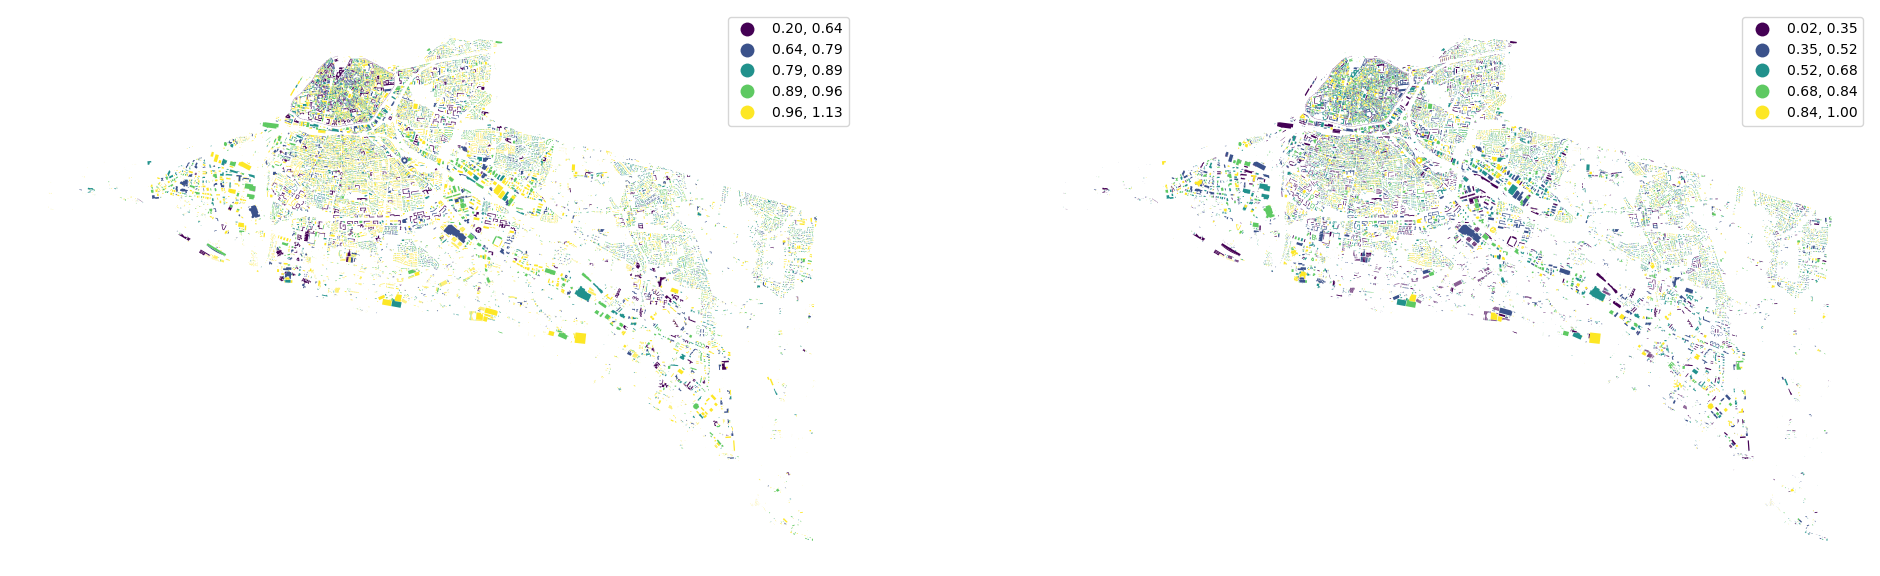

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

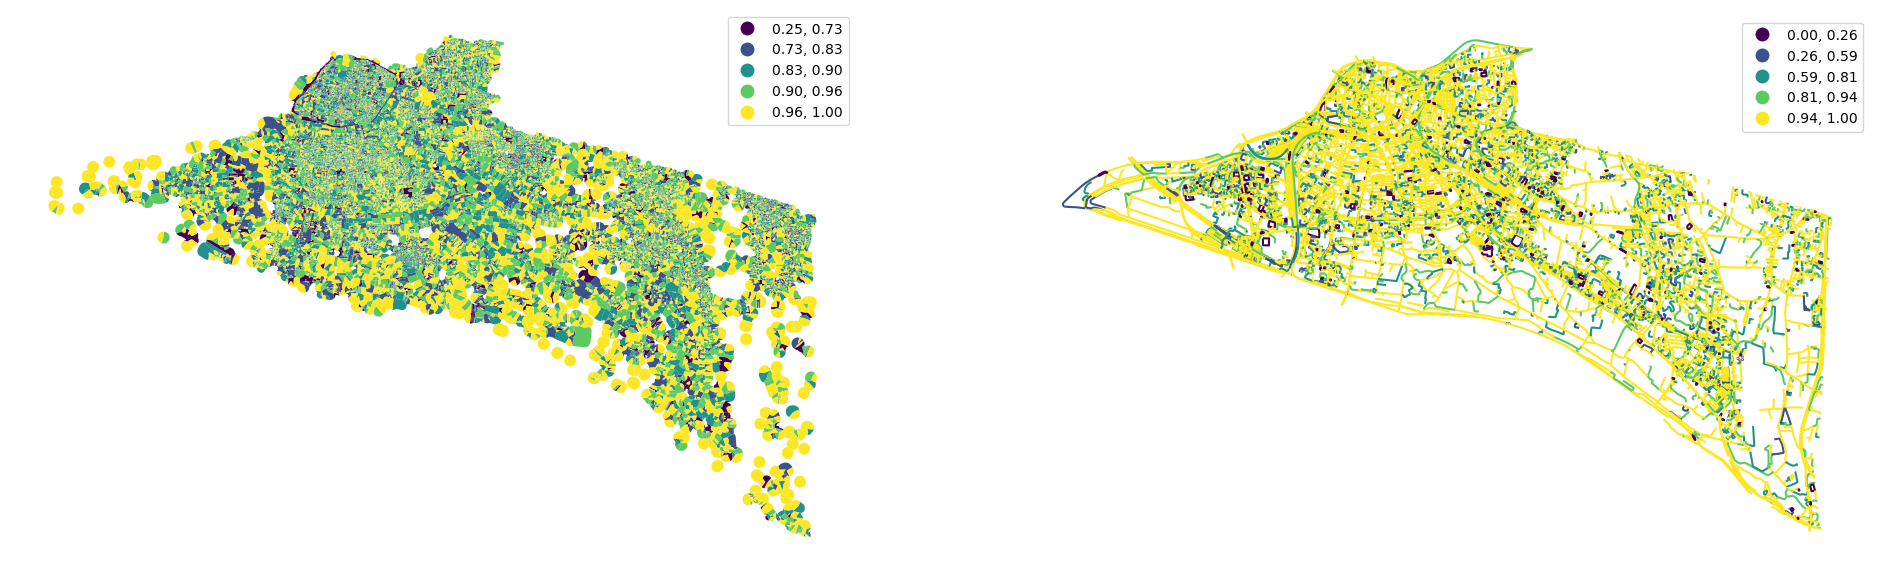

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

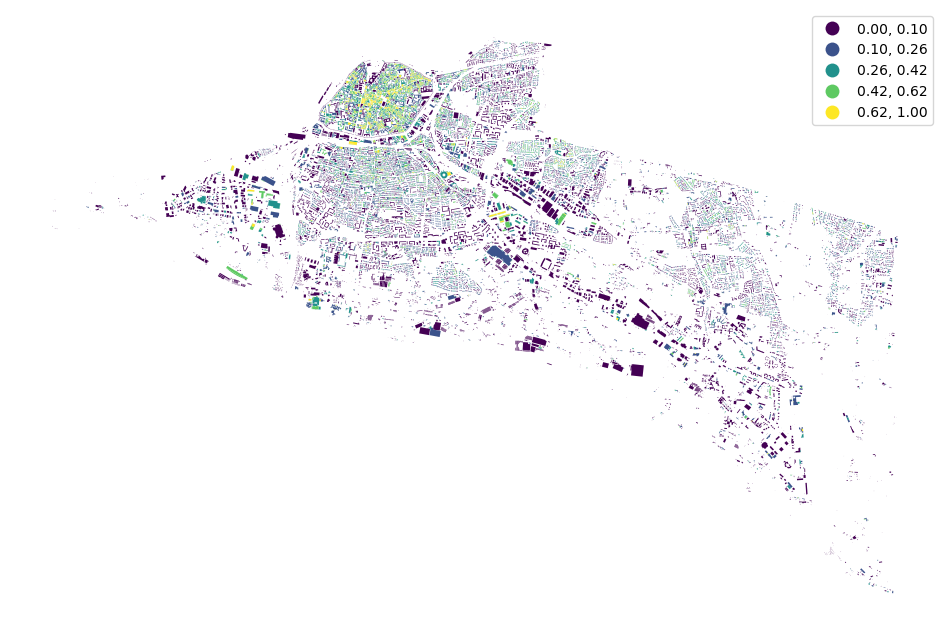

In [19]:
buildings["shared_walls"] = momepy.shared_walls(buildings) / buildings.length
buildings.plot(
    "shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True
).set_axis_off()

Generate spatial graph using `libpysal`.

In [20]:
queen_1 = libpysal.graph.Graph.build_contiguity(tessellation, rook=False)

In [21]:
tessellation["neighbors"] = momepy.neighbors(
    tessellation, queen_1, weighted=True
)
tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]
buildings["neighbor_distance"] = momepy.neighbor_distance(buildings, queen_1)

C:\Users\edoar\AppData\Local\Temp\ipykernel_10040\2369634746.py:4: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]


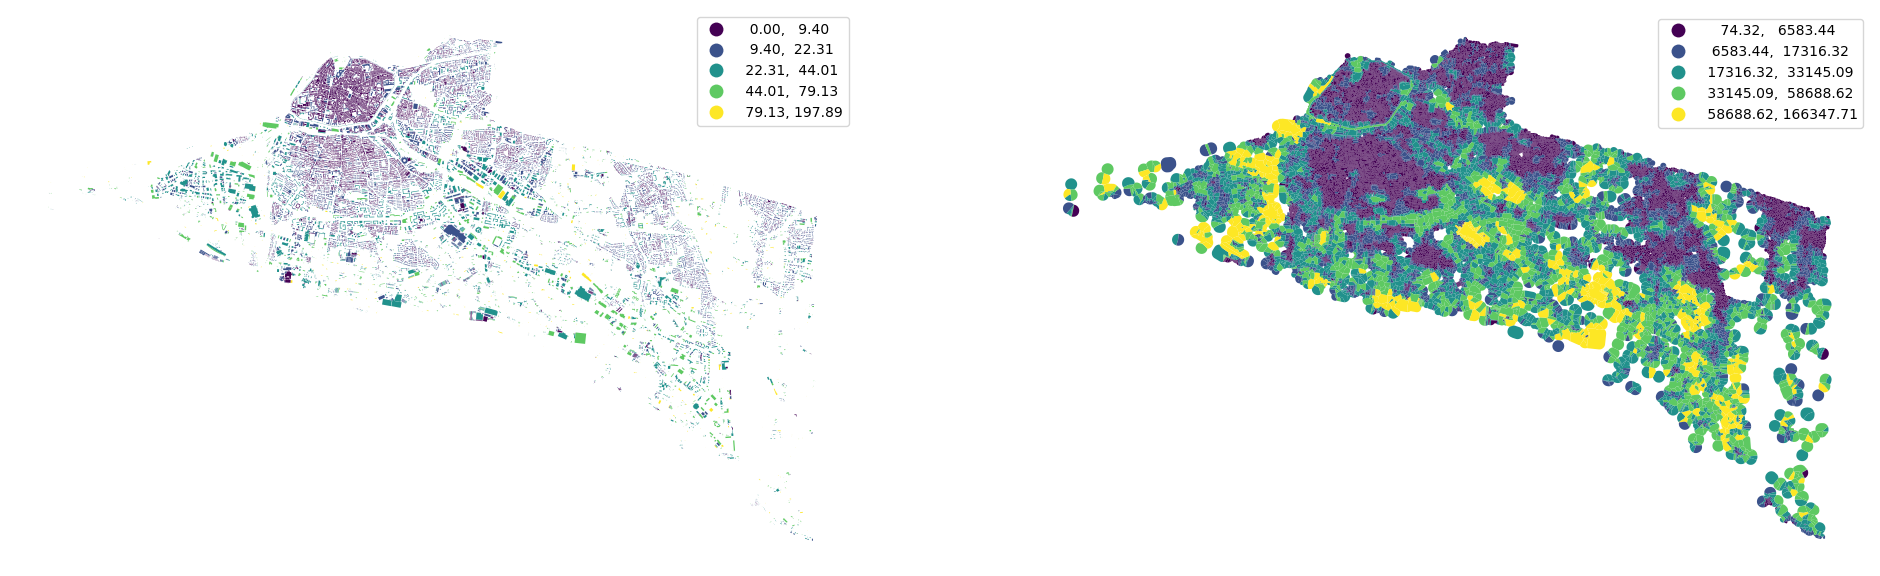

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
tessellation.plot(
    "covered_area", ax=ax[1], scheme="natural_breaks", legend=True
)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [23]:
queen_3 = queen_1.higher_order(3)
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings, queen_1, queen_3
)
buildings["adjacency"] = momepy.building_adjacency(buildings_q1, queen_3)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_distribution.py:375: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


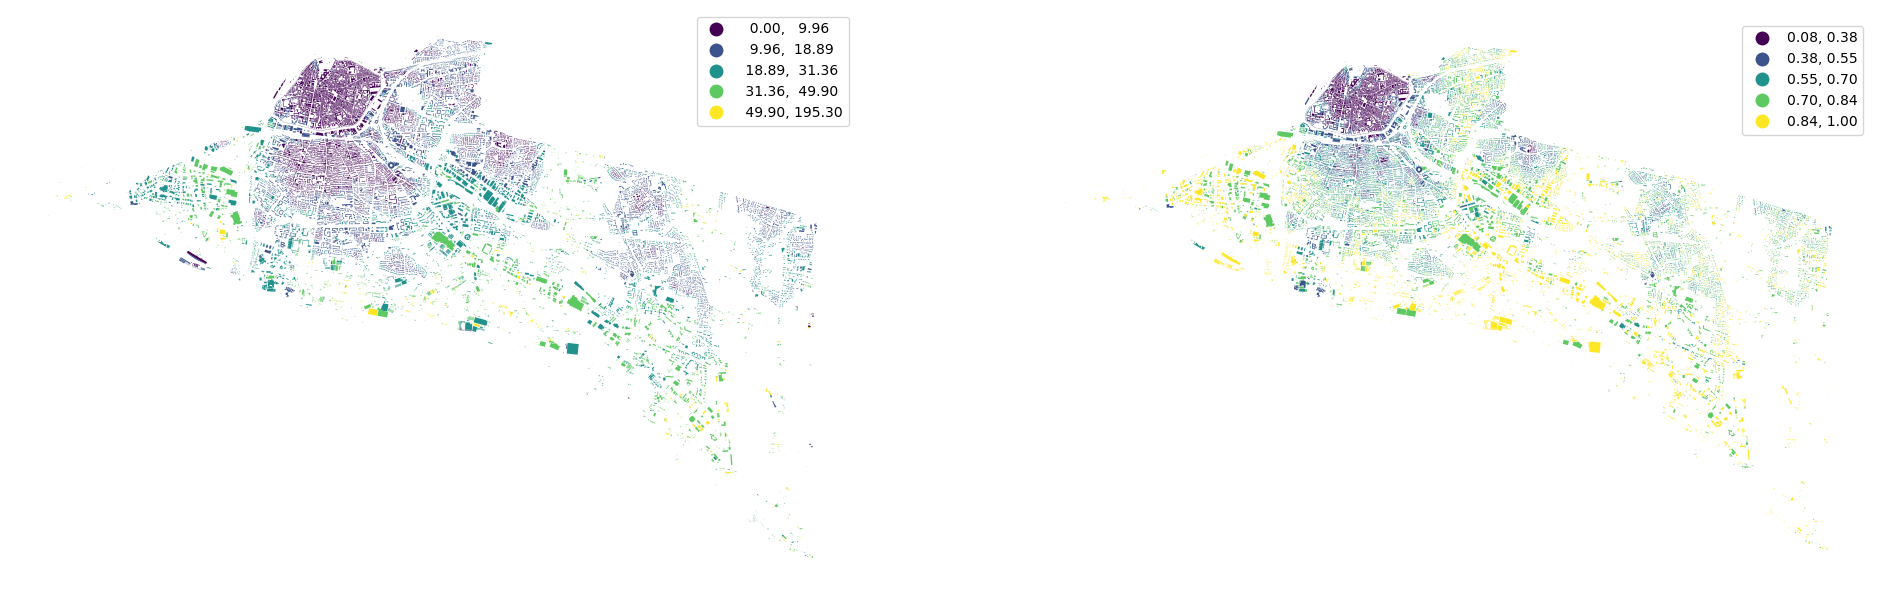

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [25]:
profile = momepy.street_profile(streets, buildings)
streets[profile.columns] = profile

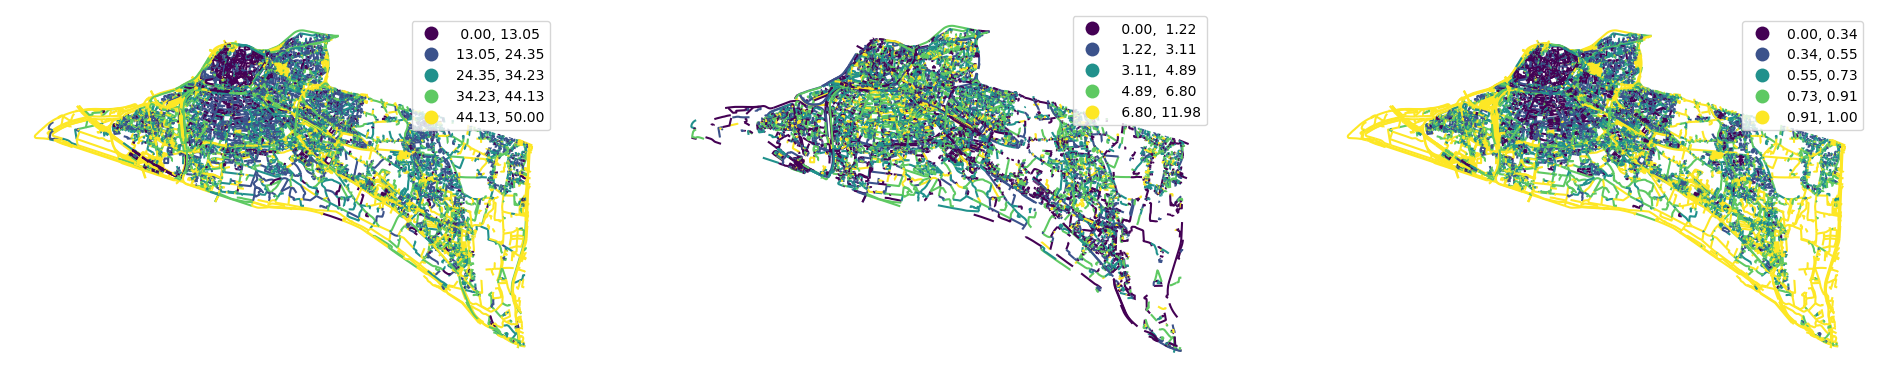

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

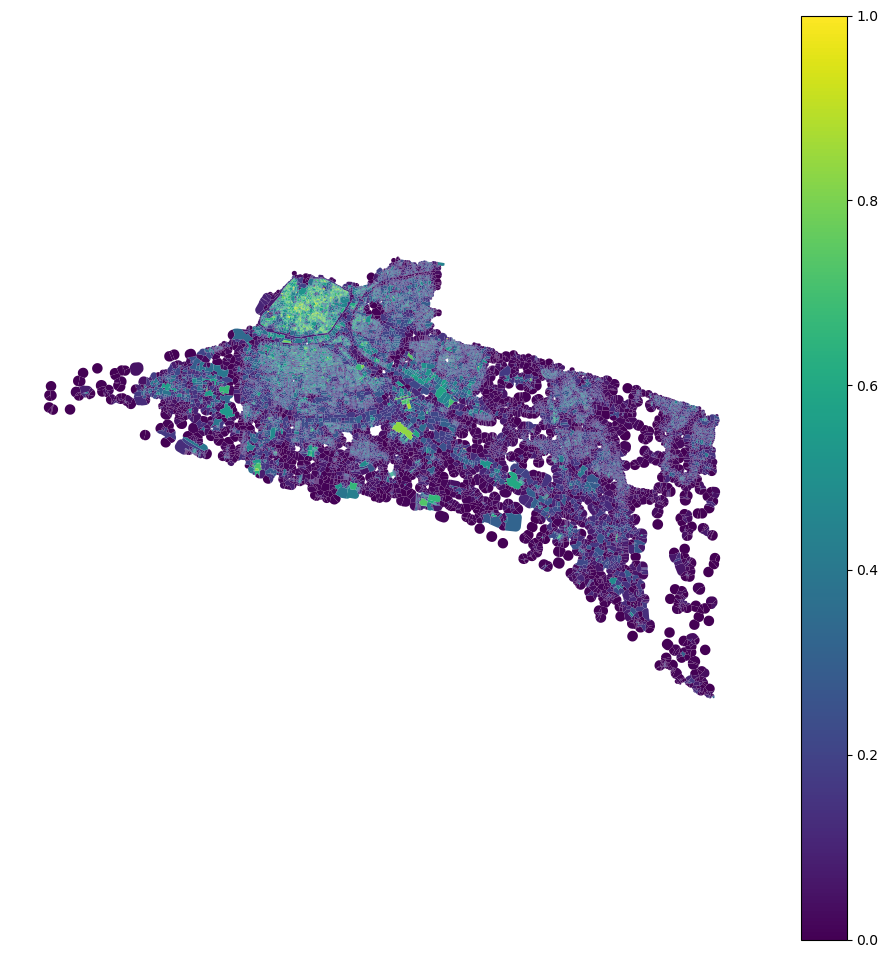

In [27]:
tessellation["car"] = buildings.area / tessellation.area
tessellation.plot(
    "car", figsize=(12, 12), vmin=0, vmax=1, legend=True
).set_axis_off()

### Connectivity

In [28]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, edges = momepy.nx_to_gdf(graph)

100%|██████████| 17179/17179 [00:33<00:00, 519.88it/s] 


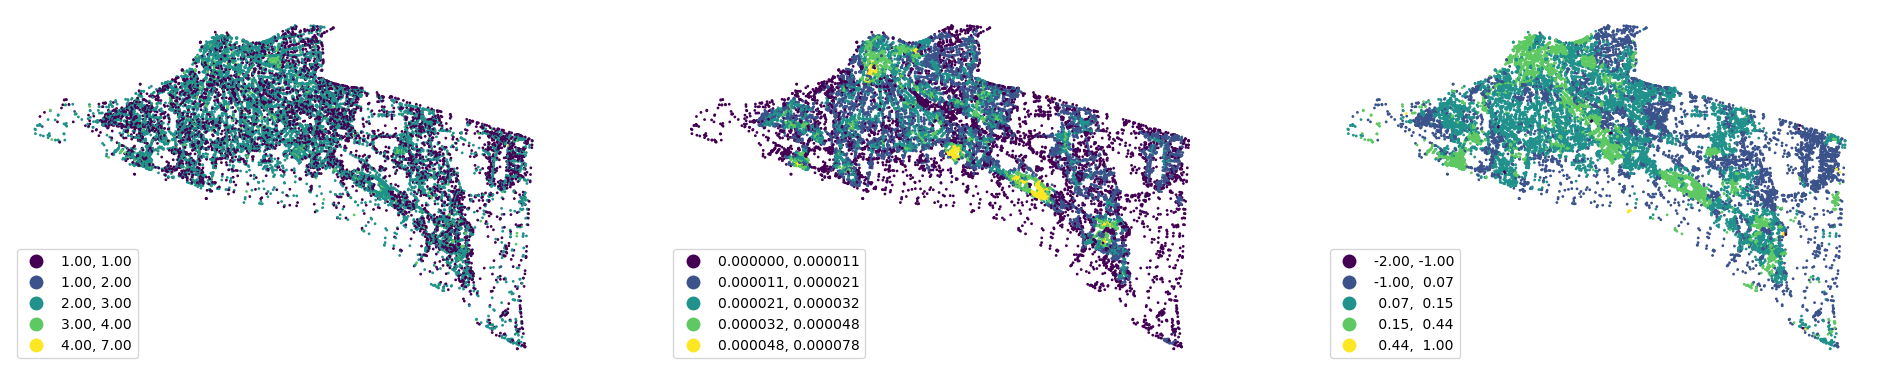

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot(
    "degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1
)
nodes.plot(
    "closeness",
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
    markersize=1,
    legend_kwds={"fmt": "{:.6f}"},
)
nodes.plot(
    "meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1
)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [30]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

Link all data together (to tessellation cells or buildings).

In [31]:
tessellation.head()

geometry  street_index  \
0  POLYGON ((-310210.647 4914862.593, -310222.036...       20759.0   
1  POLYGON ((-310233.12 4914860.451, -310233.348 ...       20759.0   
2  POLYGON ((-310233.094 4914860.006, -310233.12 ...       20759.0   
3  POLYGON ((-310188.924 4914780.233, -310204.772...       20759.0   
4  POLYGON ((-310197.397 4914840.508, -310198.303...       20759.0   

     tess_area  convexity  neighbors  covered_area       car  
0   252.363517   0.956534   0.073279   6278.108150  0.109299  
1   160.370898   0.934581   0.059034   4339.434112  0.150613  
2   253.260759   0.915638   0.046101   4675.263790  0.076658  
3  2458.329841   0.960361   0.040736  11537.672466  0.070373  
4  3361.219326   0.996880   0.027628   4058.192750  0.045235

In [32]:
buildings.head()

geometry  street_index  \
0  POLYGON ((-310221.405 4914863.983, -310225.022...       20759.0   
1  POLYGON ((-310225.022 4914864.396, -310221.405...       20759.0   
2  POLYGON ((-310222.394 4914856.896, -310222.877...       20759.0   
3  POLYGON ((-310233.408 4914817.823, -310221.644...       20759.0   
4  POLYGON ((-310200.44 4914883.629, -310194.169 ...       20759.0   

   building_area       eri  elongation  shared_walls  neighbor_distance  \
0      27.582961  0.977683    0.447911      0.156643          10.889560   
1      24.154006  0.962048    0.500601      0.445008           8.243843   
2      19.414441  0.862747    0.477767      0.359111           9.352842   
3     172.999673  0.886919    0.557672      0.000000          33.075448   
4     152.043380  0.904097    0.902771      0.000000          25.724755   

   interbuilding_distance  adjacency  edge_index  node_index  
0               21.330315   0.818182     20908.0     16673.0  
1               17.775262   0.692308     20908.0     16673.0  
2               19.778192   0.666667     20908.0     16673.0  
3               16.744835   0.677419     20908.0     16671.0  
4               14.517444   0.619048     20908.0     16673.0

In [33]:
tessellation[buildings.columns.drop(["geometry", "street_index"])] = (
    buildings.drop(columns=["geometry", "street_index"])
)
merged = tessellation.merge(
    edges.drop(columns="geometry"),
    left_on="edge_index",
    right_index=True,
    how="left",
)
merged = merged.merge(
    nodes.drop(columns="geometry"),
    left_on="node_index",
    right_index=True,
    how="left",
)

In [34]:
merged.columns

Index(['geometry', 'street_index', 'tess_area', 'convexity', 'neighbors',
       'covered_area', 'car', 'building_area', 'eri', 'elongation',
       'shared_walls', 'neighbor_distance', 'interbuilding_distance',
       'adjacency', 'edge_index', 'node_index', 'length', 'linearity', 'width',
       'openness', 'width_deviation', 'mm_len', 'node_start', 'node_end', 'x',
       'y', 'degree', 'closeness', 'meshedness', 'nodeID'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [35]:
percentiles = []
for column in merged.columns.drop(
    [
        "street_index",
        "node_index",
        "edge_index",
        "nodeID",
        "mm_len",
        "node_start",
        "node_end",
        "geometry",
    ]
):
    perc = momepy.percentile(merged[column], queen_3)
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\edoar\miniconda3\envs\urban\Lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / 

In [36]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

tess_area_25  tess_area_50  tess_area_75  convexity_25  convexity_50  \
focal                                                                         
0        702.740590   1104.794828   1488.247216      0.910305      0.949089   
1        456.567744   1072.064406   1393.271209      0.853945      0.949089   
2        283.928368   1046.885609   1348.169607      0.883469      0.950613   
3        251.781496    881.538330   1344.816007      0.850957      0.927840   
4        175.124094    476.764676   1199.360137      0.883024      0.948772   

       convexity_75  neighbors_25  neighbors_50  neighbors_75  \
focal                                                           
0          0.960361      0.037304      0.044318      0.060247   
1          0.965516      0.032998      0.044318      0.057563   
2          0.970981      0.035855      0.047782      0.060611   
3          0.984218      0.035841      0.043552      0.059034   
4          0.971290      0.043261      0.051548      0.064379   

       covered_area_25  ...          y_75  degree_25  degree_50  degree_75  \
focal                   ...                                                  
0          3664.002423  ...  4.914852e+06        1.0        3.0        3.0   
1          2934.550296  ...  4.914876e+06        1.0        3.0        3.0   
2          2936.078166  ...  4.914853e+06        1.0        3.0        3.0   
3          4889.942803  ...  4.914852e+06        1.0        1.0        3.0   
4          3137.591452  ...  4.914840e+06        1.0        1.0        3.0   

       closeness_25  closeness_50  closeness_75  meshedness_25  meshedness_50  \
focal                                                                           
0          0.000012      0.000014      0.000015       0.009524       0.009524   
1          0.000010      0.000014      0.000014       0.009524       0.010138   
2          0.000011      0.000014      0.000015       0.009524       0.010989   
3          0.000012      0.000015      0.000017       0.009524       0.047751   
4          0.000011      0.000014      0.000015       0.010871       0.012658   

       meshedness_75  
focal                 
0           0.120567  
1           0.066613  
2           0.041612  
3           0.120567  
4           0.125984  

[5 rows x 66 columns]

See the difference between original convexity and spatially lagged one.

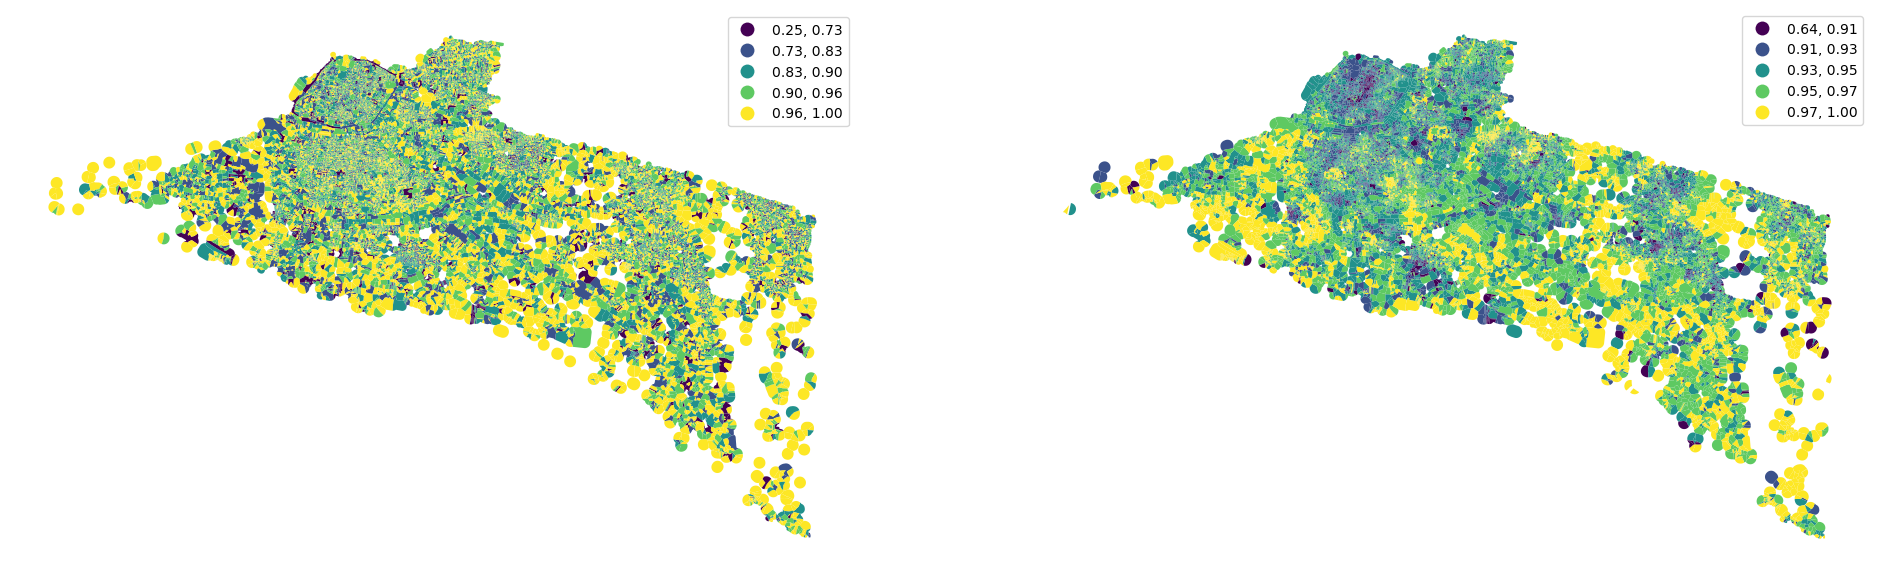

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(
    percentiles_joined["convexity_50"].values,
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

Now we can use obtained values within a cluster analysis that should detect types of urban structure.

Standardize values before clustering.

In [38]:
standardized = (
    percentiles_joined - percentiles_joined.mean()
) / percentiles_joined.std()
standardized.head()

tess_area_25  tess_area_50  tess_area_75  convexity_25  convexity_50  \
focal                                                                         
0          0.607726      0.386565      0.003439      0.741511      0.121075   
1          0.218308      0.356410     -0.041545     -0.986065      0.121075   
2         -0.054788      0.333213     -0.062907     -0.081067      0.195903   
3         -0.105641      0.180878     -0.064495     -1.077653     -0.922017   
4         -0.226904     -0.192040     -0.133388     -0.094724      0.105546   

       convexity_75  neighbors_25  neighbors_50  neighbors_75  \
focal                                                           
0         -1.718262     -0.726113     -0.956976     -0.913684   
1         -1.261700     -0.898247     -0.956976     -0.984378   
2         -0.777741     -0.784026     -0.841016     -0.904100   
3          0.394544     -0.784621     -0.982602     -0.945653   
4         -0.750344     -0.488041     -0.714956     -0.804877   

       covered_area_25  ...      y_75  degree_25  degree_50  degree_75  \
focal                   ...                                              
0            -0.079496  ... -0.436907  -1.064256    0.40043   -0.11063   
1            -0.206049  ... -0.417730  -1.064256    0.40043   -0.11063   
2            -0.205784  ... -0.435562  -1.064256    0.40043   -0.11063   
3             0.133194  ... -0.436907  -1.064256   -2.47344   -0.11063   
4            -0.170823  ... -0.445768  -1.064256   -2.47344   -0.11063   

       closeness_25  closeness_50  closeness_75  meshedness_25  meshedness_50  \
focal                                                                           
0         -0.178719     -0.399319     -0.677814      -0.977309      -1.605624   
1         -0.478821     -0.399319     -0.705978      -0.977309      -1.593768   
2         -0.368027     -0.399319     -0.612551      -0.977309      -1.577353   
3         -0.241817     -0.358541     -0.485214      -0.977309      -0.868013   
4         -0.285376     -0.399319     -0.649098      -0.957458      -1.545145   

       meshedness_75  
focal                 
0           0.252163  
1          -0.765090  
2          -1.236446  
3           0.252163  
4           0.354292  

[5 rows x 66 columns]

### How many clusters?

To determine how many clusters we should aim for, we can use a little package called `clustergram`. See its [documentation](https://clustergram.readthedocs.io) for details.

In [39]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.185 seconds.
K=3 fitted in 0.331 seconds.
K=4 fitted in 0.250 seconds.
K=5 fitted in 0.344 seconds.
K=6 fitted in 0.470 seconds.
K=7 fitted in 0.664 seconds.
K=8 fitted in 0.735 seconds.
K=9 fitted in 0.695 seconds.
K=10 fitted in 1.080 seconds.
K=11 fitted in 1.331 seconds.


Clustegram gives us also the final labels. (Normally, you would run the final clustering on much larger number of initialisations.)

In [40]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   0   0   2   2   0   4   4   2   1   6
1   0   0   0   2   2   0   4   4   2   1   6
2   0   0   0   2   2   0   4   4   2   1   6
3   0   0   0   2   2   0   4   4   2   1   6
4   0   0   0   2   2   0   4   4   2   1   6

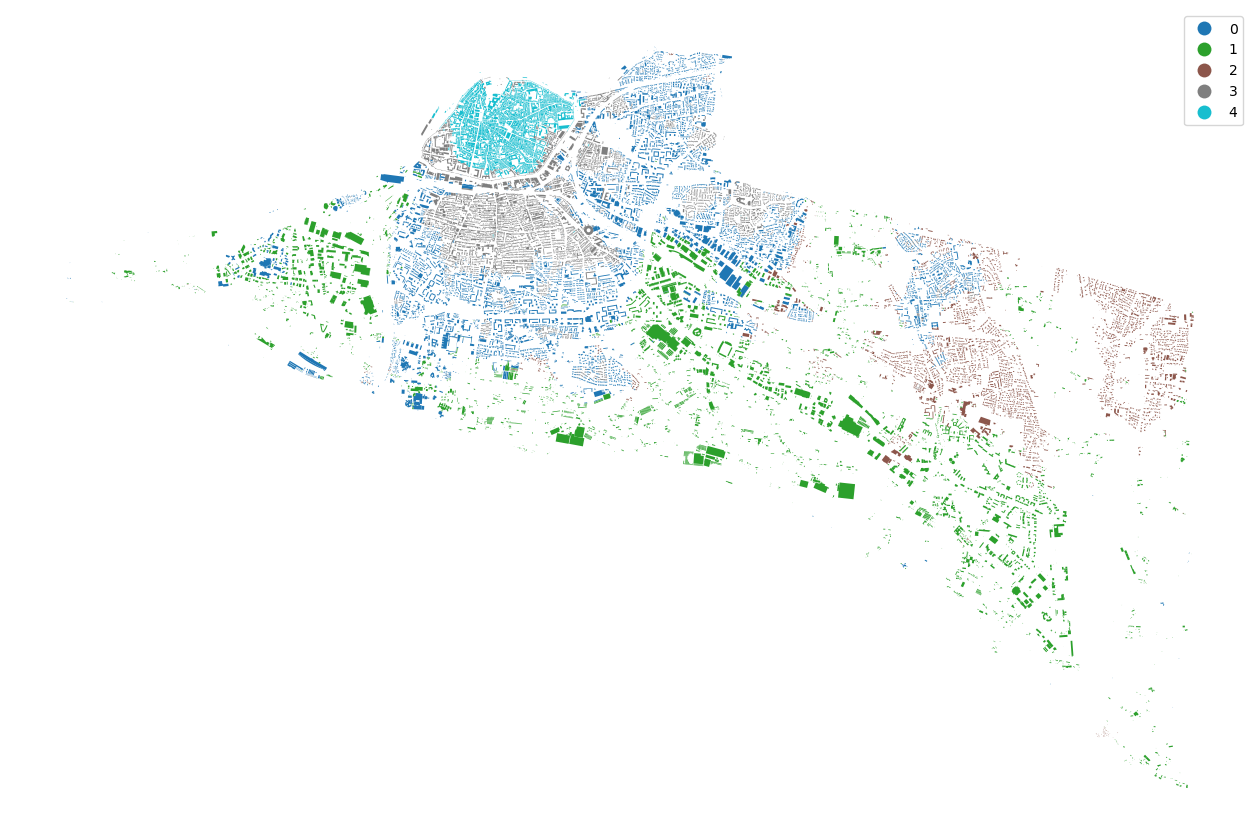

In [41]:
merged["cluster"] = cgram.labels[5].values
buildings["cluster"] = merged["cluster"]
buildings.plot(
    "cluster", categorical=True, figsize=(16, 16), legend=True
).set_axis_off()

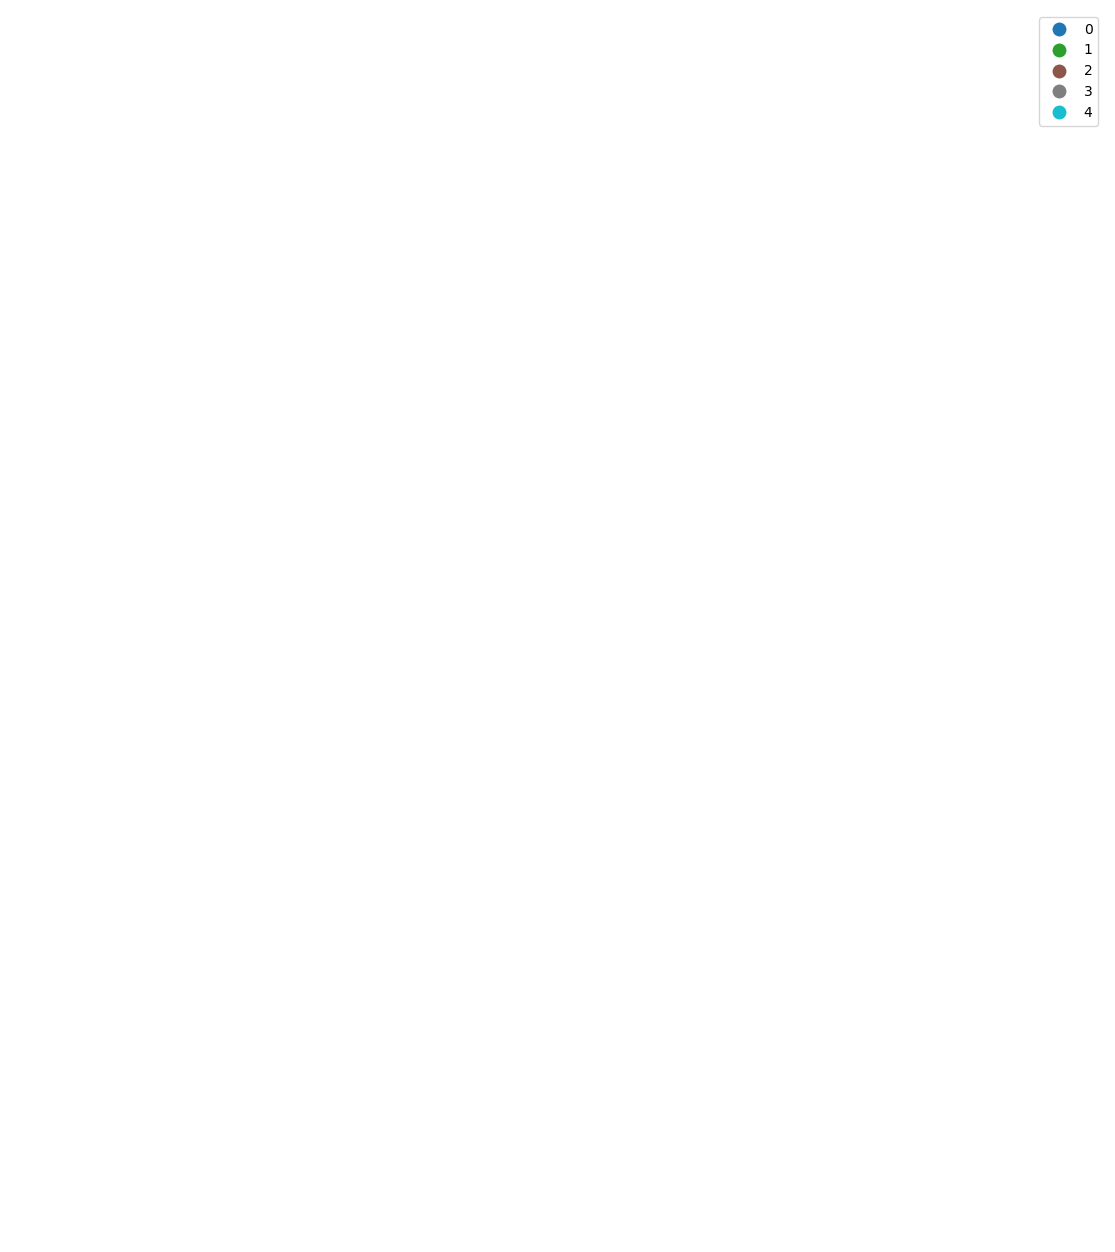

In [42]:
ax = buildings.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()